<a href="https://colab.research.google.com/github/anacamposgj/SchizoNet/blob/main/Codigo_SchizoNet_Ana_Campos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Instalación de librerias

In [7]:
%cd /content/drive/MyDrive/data_schizo

/content/drive/.shortcut-targets-by-id/1vEomjwHs8CYqhyYjTvq3SR2XfZSAz822/data_schizo


In [8]:
!pip install dipy nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 103.1 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 4.0.2
    Uninstalling nibabel-4.0.2:
      Successfully uninstalled nibabel-4.0.2


In [9]:
# Librerias procesamiento de datos y archivos
import pandas as pd
import numpy as np
import os
import glob

# Librerias de procesamiento de difussion imaging
import nibabel as nib
from dipy.align.reslice import reslice
from dipy.data import get_fnames
from dipy.io.image import load_nifti, save_nifti
from nilearn.image import resample_img
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.direction import peaks_from_model
from dipy.io import read_bvals_bvecs
from dipy.segment.mask import median_otsu
from dipy.core.gradients import gradient_table
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.io.peaks import reshape_peaks_for_visualization
from utils.processing_utils import find_files

# Librerias machine learning
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Librerias procesamiento paralelo
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

# Timing, y ejecución de scripts
from tqdm.notebook import tqdm
import subprocess
import timeit


# Descompresión de archivos

In [ ]:
!sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
%cd ..

/content/drive/.shortcut-targets-by-id/1vEomjwHs8CYqhyYjTvq3SR2XfZSAz822


extraer un archivo 7z

In [ ]:
!7za x ./MCIC/schizconnect_MCICShare_images_19250.7z.001


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./MCIC/                 1 file, 8481303686 bytes (8089 MiB)

Extracting archive: ./MCIC/schizconnect_MCICShare_images_19250.7z.001
  0% 1 Open           --
Path = ./MCIC/schizconnect_MCICShare_images_19250.7z.001
Type = Split
Physical Size = 8481303686
Volumes = 1
Total Physical Size = 8481303686
----
Path = schizconnect_MCICShare_images_19250.7z
Size = 8481303686
--
Path = schizconnect_MCICShare_images_19250.7z
Type = 7z
Physical Size = 8481303686
Headers Size = 21871
Method = LZMA2:24
Solid = +
Blocks = 5

  0%      0% - MCICShare/sub-A00036106/ses-20060101                                           

In [ ]:
!7za x /content/drive/MyDrive/data_schizo/COBRE/schizconnect_COBRE_images_19250.7z.001


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/data_schizo/COBRE/                                                   
ERROR: No more files
/content/drive/MyDrive/data_schizo/COBRE/schizconnect_COBRE_images_19250.7z.001



System ERROR:
Unknown error -2147024872


# Calulo de FA y MD

In [42]:
%pwd

'/content/drive/.shortcut-targets-by-id/1vEomjwHs8CYqhyYjTvq3SR2XfZSAz822/data_schizo'

In [45]:
def countPatients(path):
  return len([f for f in os.listdir(path) if f.startswith("sub")])

countPatients("/content/drive/.shortcut-targets-by-id/1vEomjwHs8CYqhyYjTvq3SR2XfZSAz822/data_schizo/ds003900/derivatives/trainset/")

126

In [ ]:
def main():

   def processImage(dwi_path, bval_path, bvec_path, sub_code, ses_code):
       try:

            data , affine = load_nifti(dwi_path) # Se carga el volumen de datos de DWI desde un archivo NIfTI ubicado en la ruta dwi_path. data --> array NumPy que contiene los datos de la imagen. affine --> información de afinidad o transformación espacial asociada.
            bvals, bvecs = read_bvals_bvecs(bval_path, bvec_path)
            gtab = gradient_table(bvals, bvecs)
            FA_path = os.path.join(os.path.dirname(dwi_path), f"{sub_code}_{ses_code}_dwi_tensors_fa.nii.gz")
            MD_path = os.path.join(os.path.dirname(dwi_path), f"{sub_code}_{ses_code}_dwi_tensors_md.nii.gz")
            if os.path.exists(FA_path) or os.path.exists(MD_path):
                print(f"Hay archivos previamente creados en el paciente {sub_code} , verificar.")
            else :
             print(f"Creando mascara para el paciente {sub_code}")
             maskdata , mask = median_otsu(data , vol_idx = range(1,data.shape[3]), autocrop= False)
             print(f"Mask created") #!!!!!!!!!! abajo
             tenmodel = dti.TensorModel(gtab)
             print(f"Creando tensor para el paciente {sub_code}")
             tenfit = tenmodel.fit(maskdata)
             print(f"Tensor creado para paciente {sub_code}")
             print(f"Calculando FA y MD para el paciente {sub_code}")
             MD = dti.mean_diffusivity(tenfit.evals)
             FA = dti.fractional_anisotropy(tenfit.evals)
             FA[np.isnan(FA)] = 0
             print(f"Calculado")
             save_nifti( FA_path , FA.astype(np.float32), affine)
             save_nifti(MD_path, MD.astype(np.float32), affine)
             print(f"FA y MD guardado para paciente{sub_code}")

       except Exception as e:
           print(f"Error procesando al paciente {sub_code} en la sesión {ses_code}: {e}")


   def calculateFA_MD(patient_folders):
       with ThreadPoolExecutor(max_workers=25) as executor:

           for patient_folder in patient_folders:
               sub_code = patient_folder
               session_folder = os.path.join(directory, patient_folder, next(os.walk(os.path.join(directory, patient_folder)))[1][0])
               ses_code = session_folder.split('/')[-1]
               dwi_folder = os.path.join(session_folder, 'dwi')
               dwi_path = find_files(dwi_folder, '.nii.gz')
               bval_path = find_files(dwi_folder, '.bval')
               bvec_path = find_files(dwi_folder, '.bvec')
               # Verificar si los archivos existen
               if dwi_path and bval_path and bvec_path:
                 executor.submit(processImage, dwi_path, bval_path, bvec_path, sub_code, ses_code)
               else:
                   print(f"Archivos necesarios para el paciente {sub_code} en la sesión {ses_code} no se encontraron.")



   directory = "./COBRE"

   patient_folders = [f for f in os.listdir(directory)[:126] if f.startswith("sub")]

   sub_code_folder = []
   ses_code_folder = []
   dwi_path_folder = []
   bval_path_folder = []
   bvec_path_folder = []
   peaks_path_folder = []

   for patient_folder in patient_folders:
       sub_code = patient_folder
       session_folder = os.path.join(directory, patient_folder, next(os.walk(os.path.join(directory, patient_folder)))[1][0])
       ses_code = session_folder.split('\\')[-1]
       dwi_folder = os.path.join(session_folder, 'dwi')
       dwi_path = find_files(dwi_folder, 'dwi.nii.gz')
       bval_path = find_files(dwi_folder, '.bval')
       bvec_path = find_files(dwi_folder, '.bvec')
       if dwi_path == None or bval_path == None or bvec_path == None:
              print(f"Archivos necesarios para el paciente {sub_code} en la sesión {ses_code} no se encontraron.")
       else:
         sub_code_folder.append(sub_code)
         ses_code_folder.append(ses_code)
         dwi_path_folder.append(dwi_path)
         bval_path_folder.append(bval_path)
         bvec_path_folder.append(bvec_path)

   print('Estos son los pacientes que vamos a calcular los valores de FA y MD:')
   count = 0
   for i in range(len(sub_code_folder)):
       count += 1
       print(f'Paciente: {sub_code_folder[i]} en la sesión: {ses_code_folder[i]}')

   print(f'Pacienctes totales: {count}')
   input_user = input("Do you want to calculate the FA and MD? (y/n): ")

   if input_user == "y":
        calculateFA_MD(patient_folders)
   else:
        print("Ok")

if __name__ == '__main__':
    # Este es el bloque que protege el punto de entrada del programa.
    # Solo se ejecutará si el script se ejecuta como 'main' y no cuando se importa.
    multiprocessing.freeze_support()
    main()

Estos son los pacientes que vamos a calcular los valores de FA y MD:
Paciente: sub-A00000300 en la sesión: ./COBRE/sub-A00000300/ses-20110101
Paciente: sub-A00000368 en la sesión: ./COBRE/sub-A00000368/ses-20110101
Paciente: sub-A00000456 en la sesión: ./COBRE/sub-A00000456/ses-20090101
Paciente: sub-A00000541 en la sesión: ./COBRE/sub-A00000541/ses-20100101
Paciente: sub-A00000838 en la sesión: ./COBRE/sub-A00000838/ses-20100101
Paciente: sub-A00000909 en la sesión: ./COBRE/sub-A00000909/ses-20110101
Paciente: sub-A00001181 en la sesión: ./COBRE/sub-A00001181/ses-20100101
Paciente: sub-A00001243 en la sesión: ./COBRE/sub-A00001243/ses-20110101
Paciente: sub-A00001251 en la sesión: ./COBRE/sub-A00001251/ses-20110101
Paciente: sub-A00001452 en la sesión: ./COBRE/sub-A00001452/ses-20100101
Paciente: sub-A00002405 en la sesión: ./COBRE/sub-A00002405/ses-20110101
Paciente: sub-A00002480 en la sesión: ./COBRE/sub-A00002480/ses-20110101
Paciente: sub-A00003150 en la sesión: ./COBRE/sub-A0000

# Calculo de fODF peaks utilizando dipy

In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/data_schizo

/content/drive/.shortcut-targets-by-id/1vEomjwHs8CYqhyYjTvq3SR2XfZSAz822/data_schizo


In [ ]:
!ls

'=19.0'					      MCICShare
 COBRE					      processing.py
 COBRE_metadata				      schizconnect_COBRE_assessmentData_19250.csv
 COBRE_PR				      scilpy
 deprecated_schizconnect_metaData_19250.csv   test_patients
 MCIC					      utils


In [ ]:
!du COBRE_PR/ -h

In [ ]:
!cp -r ./MCICShare/sub-A00036107/ ./test_patients #copia el contenido de sub-A00036107 al directorio test_patients

In [ ]:
import os
os.cpu_count() #obtiene el número de núcleos de la CPU del sistema

In [ ]:

# Esta funcion verifica si el paciente tiene el peaks calculado y retorna la ubicación del peaks encontrado
def filterPatients(patient_folder):
  sub_code = patient_folder # sub-A00000300
  session_folder = os.path.join(directory, patient_folder , next(os.walk(os.path.join(directory, patient_folder)))[1][0]) # ej. /content/drive/MyDrive/data_schizo/COBRE/sub-A00000300/ses-20110101
  ses_code = session_folder.split('/')[-1]  # ses-20110101
  dwi_folder = os.path.join(session_folder, 'dwi')  # /content/drive/MyDrive/data_schizo/COBRE/sub-A00000300/ses-20110101/dwi
  mask_path = find_files(dwi_folder, 'brain_mask.nii.gz')
  frf_path = find_files(dwi_folder, 'frf.txt')
  peaks_path = find_files(dwi_folder, 'peaks.nii')
  if peaks_path != None:
    return peaks_path


directory = "/content/drive/MyDrive/data_schizo/COBRE/"
patient_folders = [f for f in os.listdir(directory) if f.startswith('sub-')]
with ThreadPoolExecutor(max_workers= 5) as executor:
  count = 0
  for paths in tqdm(executor.map(filterPatients, patient_folders), desc = "Processing files" ):
      if paths is not None:
        print(f"Patient {paths} already processed {count}")
      count += 1


In [ ]:
%ls

'=19.0'                                       processing.py
 COBRE/                                       schizconnect_COBRE_assessmentData_19250.csv
 COBRE_metadata/                              scilpy/
 deprecated_schizconnect_metaData_19250.csv   test_patients/
 MCIC/                                        utils/
 MCICShare/


In [ ]:
def processImage(dwi_path, bval_path, bvec_path, sub_code, ses_code):
    try:

          data, affine = load_nifti(dwi_path)
          bvals, bvecs = read_bvals_bvecs(bval_path, bvec_path)
          gtab = gradient_table(bvals, bvecs)
          response, ration = auto_response_ssst(
              gtab ,
              data ,
              roi_radii =10,
              fa_thr = 0.7
              )
          csd_model = ConstrainedSphericalDeconvModel(gtab , response)
          csd_peaks = peaks_from_model(model = csd_model ,
                                       data = data,
                                       sphere = default_sphere,
                                       relative_peak_threshold = .5,
                                       min_separation_angle = 25,
                                       parallel = True,
                                       num_processes = 5
                                       )
          peaks_path = os.path.join(os.path.dirname(dwi_path), f"{sub_code}_{ses_code}_dwi_peaks.nii.gz")
          nib.save(nib.Nifti1Image(reshape_peaks_for_visualization(csd_peaks), affine), peaks_path)

    except Exception as e:
        print(f"Error procesando al paciente {sub_code} en la sesión {ses_code}: {e}")


def calculatefODF():
    with ThreadPoolExecutor(max_workers=1) as executor:
        for patient_folder in patient_folders:
            sub_code = patient_folder
            session_folder = os.path.join(directory, patient_folder, next(os.walk(os.path.join(directory, patient_folder)))[1][0])
            ses_code = session_folder.split('/')[-1]
            dwi_folder = os.path.join(session_folder, 'dwi')
            dwi_path = find_files(dwi_folder, '.nii.gz')
            bval_path = find_files(dwi_folder, '.bval')
            bvec_path = find_files(dwi_folder, '.bvec')
            # Verificar si los archivos existen
            if dwi_path and bval_path and bvec_path:
                executor.submit(processImage, dwi_path, bval_path, bvec_path, sub_code, ses_code)
            else:
                print(f"Archivos necesarios para el paciente {sub_code} en la sesión {ses_code} no se encontraron.")



directory = "/content/drive/MyDrive/data_schizo/test_patients"
patient_folders = [f for f in os.listdir(directory) if f.startswith('sub-')]

In [ ]:
# Llamada a la función
calculatefODF()

# Medidas y dimensiones de los datos

In [10]:
%pwd

'/content/drive/.shortcut-targets-by-id/1vEomjwHs8CYqhyYjTvq3SR2XfZSAz822/data_schizo'

In [11]:
%cd /content/drive/MyDrive/data_schizo

/content/drive/.shortcut-targets-by-id/1vEomjwHs8CYqhyYjTvq3SR2XfZSAz822/data_schizo


In [12]:
directory_schizo = "/content/drive/MyDrive/data_schizo/COBRE/"
directory_health = "/content/drive/MyDrive/data_schizo/ds003900/derivatives/trainset"


In [13]:
#toma como entrada el nombre de una carpeta de paciente. A continuación, se construye
#la ruta hacia la sesión del paciente y se extrae el código de la sesión y se crea la
#ruta hacia la carpeta que contiene las imágenes de resonancia magnética de difusión
#dentro de la sesión del paciente.


def getSizeSchizo(patient_folder):

    sub_code = patient_folder
    session_folder = os.path.join(directory_schizo , patient_folder, next(os.walk(os.path.join(directory_schizo ,patient_folder)))[1][0])
    ses_code = session_folder.split('/')[-1]
    dwi_folder = os.path.join(session_folder, 'dwi')
    FA_path = find_files(dwi_folder, "tensors_fa.nii.gz")
    if FA_path is not None:
        FA = nib.load(FA_path)
        return np.array((FA.get_fdata().shape))

    else:
      print(f"Error en el paciente {sub_code}")

def getSizeHealth(patient_folder):
   sub_code = patient_folder
   dti_path = os.path.join(directory_health, sub_code, "dti")
   FA_path = os.path.join(dti_path, f"{sub_code}__fa.nii.gz")
   if FA_path is not None:
        FA = nib.load(FA_path)
        return np.array((FA.get_fdata().shape))

   else:
      print(f"Error en el paciente {sub_code}")

patient_health_folders = [f for f in os.listdir(directory_health)]
patient_schizo_folders = [f for f in os.listdir(directory_schizo)[:126] if f.startswith('sub-')]

with ThreadPoolExecutor(max_workers= 5) as executor:
  sizes_schizo = []
  sizes_health = []
  for size in tqdm(executor.map(getSizeSchizo, patient_schizo_folders), desc="Calculating sizes schizo", total= len(patient_schizo_folders)):
            sizes_schizo.append(size)
  for size in tqdm(executor.map(getSizeHealth, patient_health_folders), desc="Calculating sizes sanos", total= len(patient_schizo_folders)):
            sizes_health.append(size)



Calculating sizes schizo:   0%|          | 0/126 [00:00<?, ?it/s]

Calculating sizes sanos:   0%|          | 0/126 [00:00<?, ?it/s]

In [14]:
#Saber el tamaño de todas las dimensiones

def getSizeStats(sizes):

   dm_1 = []
   dm_2 = []
   dm_3 = []
   dm_4 = []
   index = 0
   while index < len(sizes):
      dm_1.append(sizes[index][0])
      dm_2.append( sizes[index][1])
      dm_3.append(sizes[index][2])
      index += 1

   dm_1 = np.array(dm_1)
   dm_2 = np.array(dm_2)
   dm_3 = np.array(dm_3)
   mean_shape = np.array([ int(round(dm_1.mean())), int(round(dm_2.mean())), int(round(dm_3.mean()))] )
   min_shape = np.array([ int(round(dm_1.min())), int(round(dm_2.min())), int(round(dm_3.min())) ])
   max_shape = np.array([ int(round(dm_1.max())), int(round(dm_2.max())), int(round(dm_3.max()))] )
   print("El tamaño promedio es :" , mean_shape)
   print("El tamaño minimo es:" , mean_shape)
   print("El tamaño maximo es:" , max_shape)

In [15]:
print("Tamaño HEALTH")
getSizeStats(sizes_health)
print("Tamaño SCHIZO")
getSizeStats(sizes_schizo)

Tamaño HEALTH
El tamaño promedio es : [139 176 121]
El tamaño minimo es: [139 176 121]
El tamaño maximo es: [152 194 140]
Tamaño SCHIZO
El tamaño promedio es : [128 128  72]
El tamaño minimo es: [128 128  72]
El tamaño maximo es: [128 128  72]


# Preprocesamiento de las imagenes

In [22]:
%cd /content/drive/MyDrive/data_schizo/

/content/drive/.shortcut-targets-by-id/1vEomjwHs8CYqhyYjTvq3SR2XfZSAz822/data_schizo


In [23]:
import os
os.cpu_count()

8

In [24]:
#devolver FA y MD de COBRE

def processSchizo(patient_folder):

    sub_code = patient_folder
    session_folder = os.path.join(directory_schizo , patient_folder, next(os.walk(os.path.join(directory_schizo ,patient_folder)))[1][0])
    ses_code = session_folder.split('/')[-1]
    dwi_folder = os.path.join(session_folder, 'dwi')
    FA_path = find_files(dwi_folder, "tensors_fa.nii.gz")
    MD_path = find_files(dwi_folder,  "tensors_md.nii.gz")
    if FA_path is not None and MD_path is not None:
        FA = nib.load(FA_path)
        MD = nib.load(MD_path)
        return FA.get_fdata() ,  MD.get_fdata() , sub_code

    else:
      print(f"Error en el paciente {sub_code}")

#devuelve FA y MD de tractoinferno
def processHealth(patient_folder):
   sub_code = patient_folder
   dti_path = os.path.join(directory_health, sub_code, "dti")
   FA_path = os.path.join(dti_path, f"{sub_code}__fa.nii.gz")
   MD_path = os.path.join(dti_path, f"{sub_code}__md.nii.gz")
   if FA_path is not None and MD_path is not None:
        FA = nib.load(FA_path)
        MD = nib.load(MD_path)
        FA_res = resample_img(FA, FA.affine, (128,128,72))
        MD_res = resample_img(MD ,MD.affine, (128,128,72))
        return FA_res.get_fdata() , MD_res.get_fdata(), sub_code

   else:
      print(f"Error en el paciente {sub_code}")


#Definir las dimensiones esperadas de las imágenes
expected_shape = (128, 128, 72)
dtype = np.float32

#Rutas a los conjuntos de datos
directory_schizo = "/content/drive/MyDrive/data_schizo/COBRE/"
directory_health = "/content/drive/MyDrive/data_schizo/ds003900/derivatives/trainset"

#Obtener listas de carpetas de pacientes
patient_health_folders = [f for f in os.listdir(directory_health) if f.startswith("sub")]
patient_schizo_folders = [f for f in os.listdir(directory_schizo)[:126] if f.startswith('sub-')]

#Pre-alojar arrays de NumPy
fa_array = np.empty((len(patient_health_folders) + len(patient_schizo_folders),) + expected_shape, dtype=dtype)
md_array = np.empty((len(patient_health_folders) + len(patient_schizo_folders),) + expected_shape, dtype=dtype)
labels_array = np.empty(len(patient_health_folders) + len(patient_schizo_folders), dtype=np.uint8)
sub_list = []

# ThreadPoolExecutor para procesar las imagenes de forma concurrente para los pacientes esquizofrenicos
with ThreadPoolExecutor(max_workers=10) as executor:
    #procesar pacientes esquizofrenicos
    results = list(tqdm(executor.map(processSchizo, patient_schizo_folders), total=len(patient_schizo_folders)))
    for i, (fa_data , md_data, sub_code) in enumerate(results):
        fa_array[i] = fa_data
        md_array[i] = md_data
        labels_array[i] = 1
        sub_list.append(sub_code)

# Ahora procesar los pacientes sanos
health_start_index = len(patient_schizo_folders)
with ThreadPoolExecutor(max_workers = 10) as executor:
  results = list(tqdm(executor.map(processHealth , patient_health_folders ), total = len(patient_health_folders)))
  for i , (fa_data, md_data, sub_code) in enumerate(results):
     fa_array[health_start_index + i] = fa_data
     md_array[health_start_index + i] = md_data
     labels_array[health_start_index + i] = 0
     sub_list.append(sub_code)

# for i, patient_folder in enumerate(tqdm(patient_health_folders, total=len(patient_health_folders))):
#     img_data, sub_code = processHealth(patient_folder)
#     data_array[health_start_index + i] = img_data
#     labels_array[health_start_index + i] = 0
#     sub_list.append(sub_code)

# Filtrar arrays para pacientes esquizofrénicos
fa_array_esquizo = fa_array[labels_array == 1]
md_array_esquizo = md_array[labels_array == 1]

# Filtrar arrays para pacientes sanos
fa_array_sano = fa_array[labels_array == 0]
md_array_sano = md_array[labels_array == 0]


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

# Comprobación

In [28]:
import pandas as pd
import plotly.express as px
model_data = pd.DataFrame({ "label" : labels_array , "patient" : sub_list })
counts = model_data['label'].value_counts()
label_count = pd.DataFrame({"label" : model_data['label'].unique(), "count" : [counts[0] , counts[1]]})
px.bar(label_count , x = "label", y = "count")

In [29]:
model_data[model_data['label'] == 1]


,label,patient
0,1,sub-A00000300
1,1,sub-A00000368
2,1,sub-A00000456
3,1,sub-A00000541
4,1,sub-A00000838
...,...,...
121,1,sub-A00027616
122,1,sub-A00027755
123,1,sub-A00027787
124,1,sub-A00027969


In [30]:
model_data[model_data['label'] == 0]

,label,patient
126,0,sub-1001
127,0,sub-1002
128,0,sub-1003
129,0,sub-1004
130,0,sub-1005
...,...,...
247,0,sub-1176
248,0,sub-1177
249,0,sub-1179
250,0,sub-1180


# Desarrollo y entrenamiento del modelo

# Clasificacion binaria

Media de FA y MD para pacientes sanos y con patología

In [31]:
# Calcular la media
media_fa_sano = np.mean(fa_array_sano)
media_md_sano = np.mean(md_array_sano)
media_fa_esquizo = np.mean(fa_array_esquizo)
media_md_esquizo = np.mean(md_array_esquizo)

# Imprimir el resultado
print("La media de media_fa_sano es:", media_fa_sano)
print("La media de media_md_sano es:", media_md_sano)
print("La media de fa_array_esquizo es:", media_fa_esquizo)
print("La media de md_array_esquizo es:", media_md_esquizo)


La media de media_fa_sano es: 0.16139963
La media de media_md_sano es: 0.00070593535
La media de fa_array_esquizo es: 0.04155084
La media de md_array_esquizo es: 0.00015801247


In [32]:
import numpy as np

# Puedes convertirlo a un array de NumPy si aun no lo es
fa_array_np = np.array(fa_array)

# Calcular la media
media_fa_array = np.mean(fa_array_np)

# Imprimir el resultado
print("La media de fa_array es:", media_fa_array)

La media de fa_array es: 0.101475306


In [33]:
fa_array.shape

(252, 128, 128, 72)

In [34]:
import numpy as np

# Suponiendo que fa_array es tu array
# Puedes convertirlo a un array de NumPy si aún no lo es
#md_array_np = np.array(fa_array)

# Calcular la media
media_md_array = np.mean(md_array)

# Imprimir el resultado
print("La media de md_array es:", media_md_array)

La media de md_array es: 0.00043197404


In [35]:
md_array.shape

(252, 128, 128, 72)

In [36]:
data_array = np.stack((fa_array, md_array) , axis = -1)
data_array.shape

(252, 128, 128, 72, 2)

In [37]:
import numpy as np

# Suponiendo que data_array y labels_array son tus arreglos
indices = np.arange(252)  # Crear un arreglo de índices
np.random.seed(355)
np.random.shuffle(indices)  # Desordenar los índices

# Reordenar data_array y labels_array usando los índices desordenados
data_array_shuffled = data_array[indices]
labels_array_shuffled = labels_array[indices]


In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, concatenate, GlobalAveragePooling3D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2

def InceptionModule(input_layer, filter_sizes):
    # Ramas del módulo Inception
    branch1 = Conv3D(filter_sizes[0], (1, 1, 1), padding='same', activation='relu')(input_layer)
    branch2 = Conv3D(filter_sizes[1], (1, 1, 1), padding='same', activation='relu')(input_layer)
    branch2 = Conv3D(filter_sizes[2], (3, 3, 3), padding='same', activation='relu')(branch2)
    branch3 = Conv3D(filter_sizes[3], (1, 1, 1), padding='same', activation='relu')(input_layer)
    branch3 = Conv3D(filter_sizes[4], (5, 5, 5), padding='same', activation='relu')(branch3)
    branch4 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same')(input_layer)
    branch4 = Conv3D(filter_sizes[5], (1, 1, 1), padding='same', activation='relu')(branch4)

    # Concatenar las salidas de las diferentes ramas
    output_layer = concatenate([branch1, branch2, branch3, branch4], axis=-1)

    return output_layer

def build_inception_model(input_shape):
    input_layer = Input(input_shape)

    # Capa Inception 1
    x = InceptionModule(input_layer, [12, 24, 32, 32, 64, 6])  #número de filtros #utiliza la función InceptionModule para aplicar un módulo Inception a la capa de entrada input_layer
    x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = GlobalAveragePooling3D()(x)
    x = Dense(16, activation='relu', kernel_regularizer= l1_l2(l1=1e-5, l2=1e-4))(x)
    x = Dropout(0.7)(x)  #tasa de dropout
    # Capa de salida
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Crea el modelo
input_shape = (128, 128, 72, 2)
model = build_inception_model(input_shape)

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 72, 2)]    0         []                            
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 72, 24)     72        ['input_1[0][0]']             
                                                                                                  
 conv3d_3 (Conv3D)           (None, 128, 128, 72, 32)     96        ['input_1[0][0]']             
                                                                                                  
 max_pooling3d (MaxPooling3  (None, 128, 128, 72, 2)      0         ['input_1[0][0]']             
 D)                                                                                           

In [40]:
X_train, X_val, y_train, y_val = train_test_split(data_array, labels_array.reshape(-1,1), test_size=0.85, random_state= 124142)


In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size= 1, callbacks=[early_stopping])


Epoch 1/150
37/37 [==============================] - 97s 2s/step - loss: 0.6543 - accuracy: 0.6216 - val_loss: 0.6321 - val_accuracy: 0.4884
Epoch 2/150
37/37 [==============================] - 68s 2s/step - loss: 0.6242 - accuracy: 0.5135 - val_loss: 0.5946 - val_accuracy: 0.4884
Epoch 3/150
37/37 [==============================] - 70s 2s/step - loss: 0.6014 - accuracy: 0.5946 - val_loss: 0.5499 - val_accuracy: 0.4884
Epoch 4/150
37/37 [==============================] - 70s 2s/step - loss: 0.6178 - accuracy: 0.5946 - val_loss: 0.4500 - val_accuracy: 1.0000
Epoch 5/150
37/37 [==============================] - 70s 2s/step - loss: 0.4896 - accuracy: 0.7297 - val_loss: 0.3463 - val_accuracy: 1.0000
Epoch 6/150
37/37 [==============================] - 70s 2s/step - loss: 0.3798 - accuracy: 0.8108 - val_loss: 0.2428 - val_accuracy: 1.0000
Epoch 7/150
37/37 [==============================] - 70s 2s/step - loss: 0.3458 - accuracy: 0.7297 - val_loss: 0.1549 - val_accuracy: 1.0000
Epoch 8/150
3

In [41]:
model_path = "inception_model_schizo.keras"
model = tf.keras.models.load_model(model_path)
# Hacer predicciones en el conjunto de datos de prueba
y_pred = model.predict( X_val)

# Calcular la precisión
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(tf.argmax(y_val, axis=1), tf.argmax(y_pred, axis=1))
final_accuracy = accuracy.result().numpy()

ResourceExhaustedError: Graph execution error:

Detected at node model/conv3d_3/Conv3D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-41-8c385f1b45ed>", line 4, in <cell line: 4>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

OOM when allocating tensor with shape[32,32,128,128,72] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv3d_3/Conv3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_1402]

In [ ]:
##model.save("inception_model_schizo_085_segundavez.keras")

In [ ]:
#model.save("inception_model_schizo.keras")

In [ ]:
model.save("inception_model_schizo_085_tercera.keras")

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

# Carga tu modelo
model_path = "inception_model_schizo_085_tercera.keras"
model = tf.keras.models.load_model(model_path)


#  'X_val' datos de validación y 'y_val' etiquetas verdaderas
X_val = np.random.rand(32, 128, 128, 72, 2)  # datos de validación
y_val = np.random.randint(2, size=(32,))   # Ejemplo de etiquetas verdaderas (0 o 1)

# Obtiene las predicciones del modelo en datos de validación
y_pred = model.predict(X_val)

# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# Calcula el área bajo la curva ROC (AUC-ROC)
auc = roc_auc_score(y_val, y_pred)

# Calcula la matriz de confusión para obtener sensibilidad y especificidad
tn, fp, fn, tp = confusion_matrix(y_val, (y_pred > 0.5)).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

threshold_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for threshold in threshold_values:
    y_pred_thresholded = (y_pred > threshold).astype(int)
    auc_thresholded = roc_auc_score(y_val, y_pred_thresholded)
    print(f'Threshold: {threshold}, AUC: {auc_thresholded:.4f}')

# Imprime información adicional
print(f'Área bajo la Curva (AUC): {auc:.4f}')
print(f'Sensibilidad (TPR): {sensitivity:.4f}')
print(f'Especificidad (TNR): {specificity:.4f}')

# Muestra la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC en Datos de Validación')
plt.legend()
plt.show()




ResourceExhaustedError: Graph execution error:

Detected at node model/conv3d_3/Conv3D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-45-f24fcc923c28>", line 18, in <cell line: 18>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

OOM when allocating tensor with shape[32,32,128,128,72] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv3d_3/Conv3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_67137]

In [ ]:
import tensorflow as tf
import numpy as np
import nibabel as nib
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.segment.mask import median_otsu
import dipy.reconst.dti as dti
# Cargar el modelo preentrenado
model_path = "inception_model_schizo.keras"
model = tf.keras.models.load_model(model_path)

# Función para modificar el modelo para Grad-CAM
def modify_model_for_gradcam(model, layer_name):
    gradcam_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    return gradcam_model

# Modificar el modelo para usar la última capa convolucional para Grad-CAM
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
model_for_gradcam = modify_model_for_gradcam(model, last_conv_layer_name)

# Preprocesamiento de una imagen dMRI (ajustar según sea necesario)
def preprocess_dMRI_image(data_file, bvals_file, bvecs_file, target_shape=(128, 128, 72)):
    # Carga y preprocesamiento de datos dMRI
    data_img = nib.load(data_file)
    data = data_img.get_fdata()

    # Cargar bvals y bvecs
    bvals, bvecs = read_bvals_bvecs(bvals_file, bvecs_file)
    gtab = gradient_table(bvals, bvecs)

    # Aplicar máscara
    maskdata, mask = median_otsu(data, vol_idx= [0])
    mask_img = nib.Nifti1Image(mask.astype(np.int16) , data_img.affine)

    #Reconstrucción DTI
    tenmodel = dti.TensorModel(gtab)
    tenfit = tenmodel.fit(maskdata)

    # calculando FA y MD
    FA = dti.fractional_anisotropy(tenfit.evals)
    FA[np.isnan(FA)] = 0
    FA = np.clip(FA, 0, 1)
    MD = dti.mean_diffusivity(tenfit.evals)

    # resampling
    FA_img = nib.Nifti1Image(FA, data_img.affine)
    MD_img = nib.Nifti1Image(MD, data_img.affine)
    FA_resampled = resample_img(FA_img, FA_img.affine, target_shape=target_shape).get_fdata()
    MD_resampled = resample_img(MD_img, MD_img.affine, target_shape=target_shape).get_fdata()

    #combinar FA y MD en un solo array con dos canales
    combined_data = np.stack((FA_resampled, MD_resampled), axis=-1)
    combined_data = np.expand_dims(combined_data, axis=0)

    return combined_data, FA_resampled , MD_resampled, FA_img, mask_img





In [ ]:
#para cobre
data_file = "/content/drive/MyDrive/data_schizo/COBRE/sub-A00000300/ses-20110101/dwi/sub-A00000300_ses-20110101_run-02_dwi.nii.gz"
bvals_file = "/content/drive/MyDrive/data_schizo/COBRE/sub-A00000300/ses-20110101/dwi/sub-A00000300_ses-20110101_run-01_dwi.bval"
bvecs_file = "/content/drive/MyDrive/data_schizo/COBRE/sub-A00000300/ses-20110101/dwi/sub-A00000300_ses-20110101_run-02_dwi.bvec"
preprocessed_image, FA , MD, FA_img, mask = preprocess_dMRI_image(data_file, bvals_file, bvecs_file)

In [ ]:
#Pra MCICShare
data_file = "/content/drive/MyDrive/data_schizo/MCICShare/sub-A00036106/ses-20060101/dwi/sub-A00036106_ses-20060101_run-03_dwi.nii.gz"
bvals_file = "/content/drive/MyDrive/data_schizo/MCICShare/sub-A00036106/ses-20060101/dwi/sub-A00036106_ses-20060101_run-02_dwi.bval"
bvecs_file = "/content/drive/MyDrive/data_schizo/MCICShare/sub-A00036106/ses-20060101/dwi/sub-A00036106_ses-20060101_run-02_dwi.bvec"
preprocessed_image, FA , MD, FA_img, mask = preprocess_dMRI_image(data_file, bvals_file, bvecs_file)

KeyboardInterrupt: ignored

In [ ]:
#para tractoinferno
data_file = "/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1135/dwi/sub-1135__dwi.nii.gz"
bvals_file = "/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1135/dwi/sub-1135__dwi.bval"
bvecs_file = "/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1135/dwi/sub-1135__dwi.bvec"
preprocessed_image, FA , MD, FA_img, mask = preprocess_dMRI_image(data_file, bvals_file, bvecs_file)




In [ ]:
fa_health = nib.load("/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1135/dti/sub-1135__fa.nii.gz")
md_health = nib.load("/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1135/dti/sub-1135__md.nii.gz")
target_shape = (128, 128, 72)
FA_resampled = resample_img(fa_health, fa_health.affine, target_shape=target_shape).get_fdata()
MD_resampled = resample_img(md_health, md_health.affine, target_shape=target_shape).get_fdata()
combined_data = np.stack((FA_resampled, MD_resampled), axis=-1)
preprocessed_image = np.expand_dims(combined_data, axis=0)


In [ ]:
def compute_gradcam(model, img_array, layer_name):
    # Crear un modelo que mapea la entrada y la salida a los gradientes
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Grabar la operación de gradientes
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        # Asegurarse de que estamos trabajando con el tensor de predicciones correcto
        if isinstance(predictions, list):
            predictions = predictions[-1]

        loss = predictions[:, 0]
    print(predictions)

    # Calcular gradientes
    grads = tape.gradient(loss, conv_outputs)

    # Procesamiento de gradientes y salidas
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2), keepdims=True)

    conv_outputs = conv_outputs[0]
    conv_outputs = conv_outputs * pooled_grads
    conv_outputs = tf.reduce_mean(conv_outputs, axis=-1)

    # Normalización del mapa de calor
    heatmap = tf.maximum(conv_outputs, 0) / tf.math.reduce_max(conv_outputs)

    return heatmap.numpy()





 ['input_5', 'max_pooling3d_13', 'conv3d_23', 'conv3d_25', 'conv3d_27', 'conv3d_22', 'conv3d_24', 'conv3d_26', 'concatenate_3', 'max_pooling3d_14', 'global_average_pooling3d_4', 'dense_8', 'dropout_4', 'dense_9'].

  Existing layers are: ['input_5', 'max_pooling3d_12', 'conv3d_37', 'conv3d_39', 'conv3d_41', 'conv3d_36', 'conv3d_38', 'conv3d_40', 'concatenate_6', 'max_pooling3d_13', 'global_average_pooling3d_4', 'dense_8', 'dropout_4', 'dense_9'].

In [ ]:
FA_resampled.shape

(128, 128, 72)

In [ ]:
FA.shape


(128, 128, 72)

In [ ]:
from nilearn.plotting import view_img

view_img(FA_img, bg_img= mask)

NameError: ignored

In [ ]:
[layer.name for layer in model.layers if 'conv' in layer.name]

['conv3d_37', 'conv3d_39', 'conv3d_36', 'conv3d_38', 'conv3d_40', 'conv3d_41']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def visualize_heatmap_and_fa(heatmap, FA_resampled, slice_index):
    # Selecciona el corte del mapa de calor
    heatmap = heatmap[0]
    heatmap_slice = (heatmap[:, :, slice_index] - np.min(heatmap[:, :, slice_index])) / \
                          (np.max(heatmap[:, :, slice_index]) - np.min(heatmap[:, :, slice_index]))

    fa_slice = (FA_resampled[:, :, slice_index])

    # Preparar el subplot con mayor resolución
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Visualiza el mapa de calor
    heatmap_img = axes[0].imshow(heatmap_slice, cmap='RdBu_r', aspect='auto' , interpolation = "bicubic" )
    axes[0].set_title("Grad-CAM Heatmap")
    axes[0].axis('off')

    # Visualiza la imagen de FA
    axes[1].imshow(fa_slice, cmap='gray', aspect='auto', interpolation = "bicubic")
    axes[1].set_title("Fractional Anisotropy")
    axes[1].axis('off')

    # Añadir leyenda para el mapa de calor de manera horizontal
    fig.colorbar(heatmap_img, ax=axes, orientation='horizontal', shrink=0.75, pad=0.05)

    plt.show()

# Suponiendo que ya has obtenido el mapa de calor usando Grad-CAM
# heatmap = compute_gradcam(...)

# Suponiendo que ya tienes la imagen de FA
# FA = ...

# Crear deslizador para ajustar el corte (slice)

heatmap = compute_gradcam(model_for_gradcam, preprocessed_image, "conv3d_41")

tf.Tensor([[0.56444764]], shape=(1, 1), dtype=float32)


In [ ]:
interact(lambda slice_index: visualize_heatmap_and_fa(heatmap, FA, slice_index),
         slice_index=IntSlider(min=0, max=FA.shape[2] - 1, step=1, value=30))


interactive(children=(IntSlider(value=30, description='slice_index', max=71), Output()), _dom_classes=('widget…

<function __main__.<lambda>(slice_index)>

In [ ]:
heatmap = compute_gradcam(model_for_gradcam, data_ready, last_conv_layer_name)
# Visualizar el corte del mapa de calor
slice_index = 30  # Ajusta este valor según sea necesario
visualize_heatmap(heatmap, slice_index)

NameError: ignored

[[105   0]
 [  0 110]]


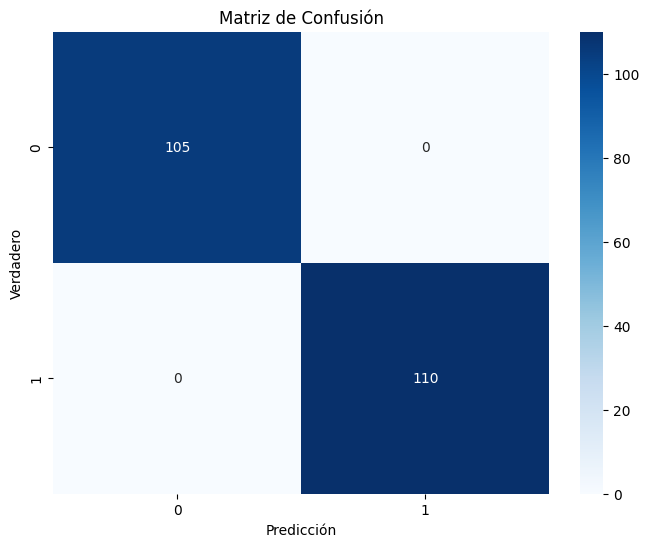

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def predict_in_batches(model, data, batch_size=2):
    predictions = []

    # Iterar sobre los datos en lotes
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        batch_predictions = model.predict(batch, verbose = False)
        predictions.extend(batch_predictions)

    return np.array(predictions)

# Utiliza esta función para obtener tus predicciones
y_pred = (predict_in_batches(model, X_val) > 0.5).astype("int32")

# Continúa con la matriz de confusión y la visualización como antes
conf_mat = confusion_matrix(y_val, y_pred)
print(conf_mat)

import seaborn as sns
import matplotlib.pyplot as plt

# Visualización de la matriz de confusión con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Hacer predicciones
y_pred = fcn_model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype("int32")  # Convertir a etiquetas binarias




NameError: ignored

In [ ]:
# Hacer predicciones en el conjunto de datos de prueba
y_pred = model.predict( X_val)

# Calcular la precisión
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(tf.argmax(y_val, axis=1), tf.argmax(y_pred, axis=1))
final_accuracy = accuracy.result().numpy()

7/7 [==============================] - 920s 129s/step


In [ ]:
print(final_accuracy)

1.0


# Otras pruebas

In [ ]:


def processSchizo(patient_folder):

    sub_code = patient_folder
    session_folder = os.path.join(directory_schizo , patient_folder, next(os.walk(os.path.join(directory_schizo ,patient_folder)))[1][0])
    ses_code = session_folder.split('/')[-1]
    dwi_folder = os.path.join(session_folder, 'dwi')
    peaks_path = find_files(dwi_folder, "peaks.nii.gz")
    if peaks_path is not None:
        peaks = nib.load(peaks_path)
        peaks_rezised = resample_img(peaks, peaks.affine , (128,128,72))
        return peaks_rezised.get_fdata(), sub_code

    else:
      print(f"Error en el paciente {sub_code}")




# Definir las dimensiones esperadas de las imágenes (ajusta esto según tus necesidades)
expected_shape = (128, 128, 72, 15)  # Por ejemplo, ajusta el 15 al número correcto de canales
dtype = np.float32  # Ajusta según la precisión que necesites

# Rutas a los conjuntos de datos
directory_schizo = "/content/drive/MyDrive/data_schizo/test/"

# Obtener listas de carpetas de pacientes
patient_schizo_folders = [f for f in os.listdir(directory_schizo) if f.startswith('sub-')]

# Pre-alojar arrays de NumPy
data_array_test = np.empty(( len(patient_schizo_folders),) + expected_shape, dtype=dtype)
sub_list_test = []

# Utilizamos ThreadPoolExecutor para procesar las imágenes de forma concurrente para los pacientes esquizofrénicos
with ThreadPoolExecutor(max_workers=7) as executor:
    # Procesar pacientes esquizofrénicos
    results = list(tqdm(executor.map(processSchizo, patient_schizo_folders), total=len(patient_schizo_folders)))
    for i, (img_data, sub_code) in enumerate(results):
        data_array_test[i] = img_data
        sub_list_test.append(sub_code)


In [ ]:
def processHealth(patient_folder):
   sub_code = patient_folder
   fodf_path = os.path.join(directory_health, sub_code, "fodf")
   peaks_path = os.path.join(fodf_path, f"{sub_code}__peaks.nii.gz")
   if peaks_path is not None:
        peaks = nib.load(peaks_path)
        resized_peaks = resample_img(peaks, peaks.affine, (128,128,72))
        return resized_peaks.get_fdata() , sub_code

   else:
      print(f"Error en el paciente {sub_code}")




# Definir las dimensiones esperadas de las imágenes (ajusta esto según tus necesidades)
expected_shape = (128, 128, 72, 15)  # Por ejemplo, ajusta el 15 al número correcto de canales
dtype = np.float32  # Ajusta según la precisión que necesites

# Rutas a los conjuntos de datos
directory_health = "../ds003900/derivatives/testset/"

# Obtener listas de carpetas de pacientes
patient_health_folders = [f for f in os.listdir(directory_health) if f.startswith('sub-')]

# Pre-alojar arrays de NumPy
data_array_test_health = np.empty(( len(patient_health_folders),) + expected_shape, dtype=dtype)

# Utilizamos ThreadPoolExecutor para procesar las imágenes de forma concurrente para los pacientes esquizofrénicos
with ThreadPoolExecutor(max_workers=7) as executor:
    # Procesar pacientes esquizofrénicos
    results = list(tqdm(executor.map(processHealth, patient_health_folders), total=len(patient_health_folders)))
    for i, (img_data, sub_code) in enumerate(results):
        data_array_test_health[i] = img_data


  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
data_array_test = np.concatenate([data_array_test, data_array_test_health])

In [ ]:
pred_schizo = fcn_model.predict(data_array_test)

2/2 [==============================] - 45s 25s/step


32.0

In [ ]:
import numpy as np
import nibabel as nib

# Función para cargar y procesar la imagen
def load_process_image(image_path):
    image = nib.load(image_path)

    # Asegurarte de que la imagen esté en las dimensiones esperadas (aquí se asumen dimensiones de ejemplo)
    if image.shape != (128, 128, 72, 15):
        image = resample_img(image, target_affine= image.affine, target_shape=(128, 128, 72))

    # Obtener los datos de la imagen y expandir las dimensiones
    image_data = image.get_fdata()
    image_data = np.expand_dims(image_data, axis=0)  # Añade una dimensión para el batch size


    return image_data

# Ruta de la imagen que quieres predecir
image_path = './test/sub-A00036188/ses-20040101/dwi/sub-A00036188_ses-20040101_dwi_peaks.nii.gz'

# Cargar y procesar la imagen
image_to_predict = load_process_image(image_path)

# Hacer la predicción
prediction = fcn_model.predict(image_to_predict)

print(f"La clase predicha es: {prediction}")


In [ ]:
# Grafica simple del modelo
tf.keras.utils.plot_model(fcn_model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
fcn_model.save("schizo_model.keras")

In [ ]:
fcn_model = tf.keras.

  0%|          | 0/32 [00:00<?, ?it/s]

# Encontrar voxels

In [ ]:
test_fodf_1001 = "../ds003900/derivatives/trainset/sub-1001/dti/sub-1001__fa.nii.gz"
test_fodf_1002 = "../ds003900/derivatives/trainset/sub-1002/dti/sub-1002__fa.nii.gz"

data_1001, affine_1001, voxel_size_1001 = load_nifti(test_fodf_1001, return_voxsize=True)

print("Shape sub_1001:", data_1001.shape)
print("Voxel sub_1001:", voxel_size_1001)

data_1002, affine_1002, voxel_size_1002 = load_nifti(test_fodf_1002, return_voxsize=True)

print("Shape sub_1002:", data_1002.shape)
print("Voxel sub_1002", voxel_size_1002)


data_1001_reslice, affine_1001_reslice = reslice(
    data_1001, affine_1001, voxel_size_1001, (3,3, 3)
)
print("Nuevo shape sub_1001:", data_1001_reslice.shape)
data_1002_reslice, affine_1002_reslice = reslice(
    data_1002, affine_1002, voxel_size_1002, (3, 3, 3)
)
print("Nuevo shape sub_1002:", data_1002_reslice.shape)

Shape sub_1001: (135, 166, 100)
Voxel sub_1001: (1.0, 1.0, 1.0)
Shape sub_1002: (137, 174, 100)
Voxel sub_1002 (1.0, 1.0, 1.0)
Nuevo shape sub_1001: (45, 55, 33)
Nuevo shape sub_1002: (46, 58, 33)


In [ ]:
pip install nibabel matplotlib


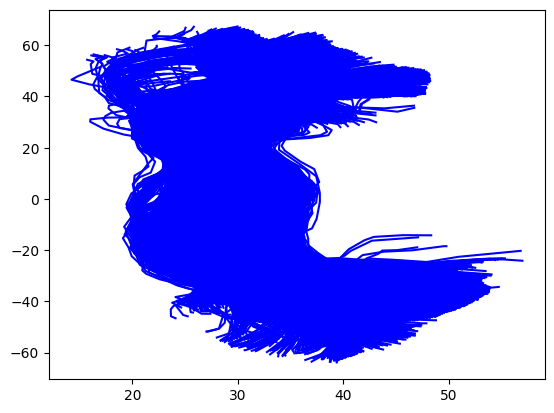

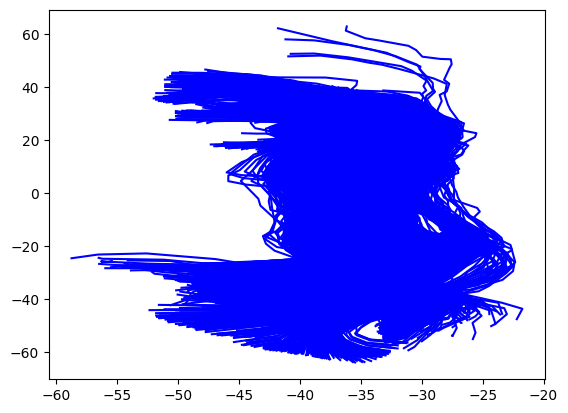

In [ ]:
import os
import matplotlib.pyplot as plt
from dipy.io.streamline import load_tractogram
from dipy.io.image import load_nifti
import nibabel as nib
from nilearn import plotting

# Directorio que contiene los archivos .trk y la carpeta de máscaras
directory_tracto = '/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1006/tractography'
directory_mask = '/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1006/mask'


# Lista de nombres de los dos archivos .trk que deseas visualizar (cámbialo según tus necesidades)
nombres_tractos = ['sub-1006__SLF_R.trk', 'sub-1006__SLF_L.trk']

# Iterar sobre los nombres de los tractos especificados
for nombre_tracto in nombres_tractos:
    # Ruta completa del archivo .trk
    ruta_tracto = os.path.join(directory_tracto, nombre_tracto)

    # Verificar si el archivo existe
    if os.path.isfile(ruta_tracto):
        # Obtener las streamlines del tracto actual
        tractogram = load_tractogram(ruta_tracto, 'same')
        streamlines = tractogram.streamlines

        # Crear una figura de matplotlib
        fig, ax = plt.subplots()

        # Visualizar las streamlines en la figura
        for streamline in streamlines:
            ax.plot(streamline[:, 0], streamline[:, 1], color='blue')  # Ajusta los índices según tus necesidades

        # Mostrar la figura
        plt.show()
    else:
        print(f"El archivo {nombre_tracto} no se encontró en el directorio: {ruta_tracto}")

# Iterar sobre las máscaras de la imagen
mask_files = ['sub-1006__mask_csf.nii', 'sub-1006__mask_gm.nii', 'sub-1006__mask_wm.nii']

# Iterar sobre las carpetas dentro del directorio de máscaras
for folder_name in os.listdir(directory_mask):
    folder_path = os.path.join(directory_mask, folder_name)

    # Verificar si es un directorio
    if os.path.isdir(folder_path):
        print(f"\nExplorando la carpeta: {folder_name}")

        # Iterar sobre los archivos de máscara en la carpeta
        for mask_file in mask_files:
            # Ruta completa de la máscara en la carpeta
            ruta_mask = os.path.join(folder_path, mask_file)

            # Imprimir la ruta antes de intentar cargar la máscara
            print(f"Intentando cargar la máscara desde: {ruta_mask}")

            # Verificar si el archivo existe
            if os.path.isfile(ruta_mask):
                # Cargar la máscara con nibabel
                mask_img = nib.load(ruta_mask)

                # Visualizar la máscara con nilearn
                plotting.plot_roi(roi_img=mask_img, title=f'Mask: {ruta_mask}', display_mode='ortho', cut_coords=None)
                plt.show()
            else:
                print(f"El archivo {mask_file} no se encontró en el directorio: {ruta_mask}")


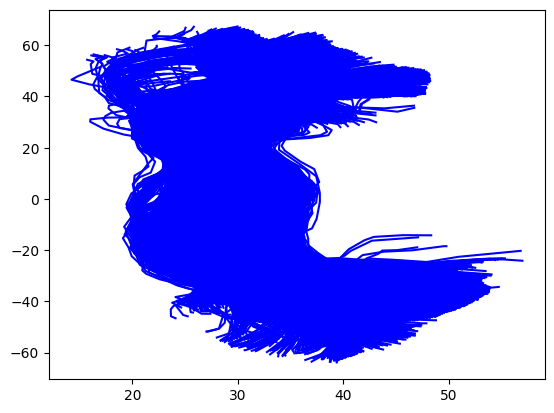

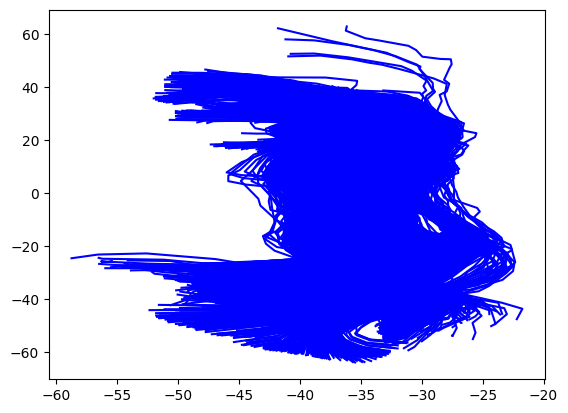

In [ ]:

import os
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
from dipy.io.streamline import load_tractogram

# Directorio que contiene los archivos .trk y la carpeta de máscaras
directory_tracto = '/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1006/tractography'
directory_mask = '/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1006/mask'

# Lista de nombres de los dos archivos .trk que deseas visualizar (cámbialo según tus necesidades)
nombres_tractos = ['sub-1006__SLF_R.trk', 'sub-1006__SLF_L.trk']

# Iterar sobre los nombres de los tractos especificados
for nombre_tracto in nombres_tractos:
    # Ruta completa del archivo .trk
    ruta_tracto = os.path.join(directory_tracto, nombre_tracto)

    # Verificar si el archivo existe
    if os.path.isfile(ruta_tracto):
        # Obtener las streamlines del tracto actual
        tractogram = load_tractogram(ruta_tracto, 'same')
        streamlines = tractogram.streamlines

        # Crear una figura de matplotlib
        fig, ax = plt.subplots()

        # Visualizar las streamlines en la figura
        for streamline in streamlines:
            ax.plot(streamline[:, 0], streamline[:, 1], color='blue')  # Ajusta los índices según tus necesidades

        # Mostrar la figura
        plt.show()
    else:
        print(f"El archivo {nombre_tracto} no se encontró en el directorio: {ruta_tracto}")

# Iterar sobre las máscaras de la imagen
mask_files = ['sub-1006__mask_csf.nii', 'sub-1006__mask_gm.nii', 'sub-1006__mask_wm.nii']

# Iterar sobre las carpetas dentro del directorio de máscaras
for folder_name in os.listdir(directory_mask):
    folder_path = os.path.join(directory_mask, folder_name)

    # Verificar si es un directorio
    if os.path.isdir(folder_path):
        print(f"\nExplorando la carpeta: {folder_name}")

        # Iterar sobre los archivos de máscara en la carpeta
        for mask_file in mask_files:
            # Ruta completa de la máscara en la carpeta
            ruta_mask = os.path.join(folder_path, mask_file)

            # Imprimir la ruta antes de intentar cargar la máscara
            print(f"Intentando cargar la máscara desde: {ruta_mask}")

            # Verificar si el archivo existe
            if os.path.isfile(ruta_mask):
                # Cargar la máscara con nibabel
                mask_img = nib.load(ruta_mask)

                # Visualizar la máscara con nilearn
                plotting.plot_roi(roi_img=mask_img, title=f'Mask: {ruta_mask}', display_mode='ortho', cut_coords=None)
                plotting.show()
            else:
                print(f"El archivo {mask_file} no se encontró en el directorio: {ruta_mask}")



In [ ]:
pip install nibabel fury nilearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.7 MB/s eta 0:00:00
  Created wheel for pygltflib: filename=pygltflib-1.16.1-py3-none-any.whl size=27085 sha256=85ee6850694835bea289fee580e75fea694a3e1325f164ab01333eb2b12def6a
  Stored in directory: /root/.cache/pip/wheels/9c/73/91/ae3a93bb6cc6dde662ed1dc48dd0ec7ca41a7bcc2a1a99b5a6
Successfully built pygltflib


In [ ]:
pip install --upgrade nibabel fury nilearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.2 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 4.0.2
    Uninstalling nibabel-4.0.2:
      Successfully uninstalled nibabel-4.0.2


In [ ]:
import os
import nibabel as nib
from nilearn import plotting
from dipy.io.streamline import load_tractogram
from fury import actor, window

# Directorio que contiene los archivos .trk y la carpeta de máscaras
directory_tracto = '/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1006/tractography'
directory_mask = '/content/drive/MyDrive/data_schizo/ds003900/derivatives/testset/sub-1006/mask'

# Lista de nombres de los dos archivos .trk que deseas visualizar (cámbialo según tus necesidades)
nombres_tractos = ['sub-1006__SLF_R.trk', 'sub-1006__SLF_L.trk']

# Crear una escena
scene = window.Scene()

# Iterar sobre los nombres de los tractos especificados
for nombre_tracto in nombres_tractos:
    # Ruta completa del archivo .trk
    ruta_tracto = os.path.join(directory_tracto, nombre_tracto)

    # Verificar si el archivo existe
    if os.path.isfile(ruta_tracto):
        # Obtener las streamlines del tracto actual
        tractogram = load_tractogram(ruta_tracto, 'same')
        streamlines = tractogram.streamlines

        # Crear un actor de líneas para las streamlines con Fury
        streamlines_actor = actor.line(streamlines, window.colors.blue)

        # Añadir el actor a la escena
        scene.add(streamlines_actor)
    else:
        print(f"El archivo {nombre_tracto} no se encontró en el directorio: {ruta_tracto}")

# Iterar sobre las máscaras de la imagen
mask_files = ['sub-1006__mask_csf.nii', 'sub-1006__mask_gm.nii', 'sub-1006__mask_wm.nii']

# Iterar sobre las carpetas dentro del directorio de máscaras
for folder_name in os.listdir(directory_mask):
    folder_path = os.path.join(directory_mask, folder_name)

    # Verificar si es un directorio
    if os.path.isdir(folder_path):
        print(f"\nExplorando la carpeta: {folder_name}")

        # Iterar sobre los archivos de máscara en la carpeta
        for mask_file in mask_files:
            # Ruta completa de la máscara en la carpeta
            ruta_mask = os.path.join(folder_path, mask_file)

            # Imprimir la ruta antes de intentar cargar la máscara
            print(f"Intentando cargar la máscara desde: {ruta_mask}")

            # Verificar si el archivo existe
            if os.path.isfile(ruta_mask):
                # Cargar la máscara con nibabel
                mask_img = nib.load(ruta_mask)

                # Crear un actor de superficie para la máscara con Fury
                mask_actor = actor.slicer(mask_img.get_data(), mask_img.affine, opacity=0.5, interpolation='nearest')

                # Añadir el actor a la escena
                scene.add(mask_actor)
            else:
                print(f"El archivo {mask_file} no se encontró en el directorio: {ruta_mask}")

# Mostrar la ventana de Fury
window.show(scene)
